<a id="top"></a>
# Cloud-Filtered Custom Mosaics

<hr>

# Notebook Summary

This notebook can be used to create custom Landsat cloud-filtered mosaics for any time period and location. The mosaics can be output as GeoTIFF products for analysis in external GIS tools. The following mosaics are possible:

Median = midpoint of spectral data
Geomedian = Australian median product with improved spectral consistency
Most-Recent = most-recent clear pixel
Max-NDVI = maximum vegetation response

Users should review the ["Cloud_Statistics" notebook](DCAL_Cloud_Statistics.ipynb) for more 
information about the cloud statistics for any given temporal and spatial combination. 
An understanding of the underlying data is important for creating a valid mosaic for further analyses.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load and Clean Data from the Data Cube](#load_data)
* [Create Mosaics](#mosaics)
* [Create GeoTIFF Output Products](#export)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
# Enable importing of utilities.
import sys
sys.path.append('..')

# Supress Warnings.
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Load Data Cube Configuration
import datacube
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = api.dc

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

**List available products for each platform**

In [2]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


platform               name
id                              
2   LANDSAT_7  ls7_usgs_sr_scene

In [3]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


platform               name
id                              
1   LANDSAT_8  ls8_usgs_sr_scene

**Choose product**

<p style="color:red";><b>CHANGE INPUTS BELOW

In [5]:
# Select a Product and Platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal

# product = "ls7_usgs_sr_scene"
# platform = "LANDSAT_7"

product = "ls8_usgs_sr_scene"
platform = "LANDSAT_8"

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [6]:
from utils.data_cube_utilities.dc_load import get_product_extents
from utils.data_cube_utilities.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product)

# Print the extents of the combined data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, min_max_dates)))

Latitude Extents: (-12.63361111121218, 18.40166666681388)
Longitude Extents: (-25.47250000020378, 44.01000000035208)
Time Extents: ['2013-03-21', '2020-01-27']


**Visualize the available area**

In [7]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(full_lat, full_lon)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [14]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# HINT: Keep your region small (<0.5 deg square) to avoid memory overload issues
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

# Mombasa, Kenya
latitude = (-4.1, -3.9) 
longitude = (39.5, 39.7) 

# Freetown, Sierra Leone
# latitude = (8.3267, 8.5123)
# longitude = (-13.3109, -13.1197 )

# Tano-Offin Forest - Ghana
# latitude = (6.5814, 6.8978 ) 
# longitude = (-2.2955, -1.9395) 

# Vietnam
# latitude = (10.9358, 11.0358)
# longitude = (107.1899, 107.2899)

# Time Period
time_extents = ('2018-01-01', '2018-12-31')

**Visualize the selected area**

In [15]:
display_map(latitude,longitude)

## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>

In [16]:
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [17]:
# Displays the first few values of each data array to check the content
# Latitude and Longitude numbers = number of pixels in each dimension
# Time = number of time slices in the dataset

landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 721, time: 44)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-15T07:31:16.507811 ... 2018-12-17T07:31:29.649793
  * latitude   (latitude) float64 -3.9 -3.9 -3.9 -3.901 ... -4.099 -4.1 -4.1
  * longitude  (longitude) float64 39.5 39.5 39.5 39.5 ... 39.7 39.7 39.7 39.7
Data variables:
    red        (time, latitude, longitude) int16 -9999 -9999 -9999 ... 617 578
    green      (time, latitude, longitude) int16 -9999 -9999 -9999 ... 687 636
    blue       (time, latitude, longitude) int16 -9999 -9999 -9999 ... 669 686
    nir        (time, latitude, longitude) int16 -9999 -9999 -9999 ... 656 650
    swir1      (time, latitude, longitude) int16 -9999 -9999 -9999 ... 706 602
    swir2      (time, latitude, longitude) int16 -9999 -9999 -9999 ... 654 557
    pixel_qa   (time, latitude, longitude) uint16 1 1 1 1 1 ... 416 416 416 352
Attributes:
    crs:      EPSG:4326

>### Masking out Clouds

In [18]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)
cleaned_dataset = landsat_dataset.where(cloud_mask)

## <span id="mosaics">Create Mosaics [&#9652;](#top)</span>

> **Median Mosaic**  
>  Masks clouds from imagery using the median-valued cloud-free pixels in the time series.
>  More specifically, each band (e.g. red) of each pixel is assigned its median across time.
>  So this mosaic method generates values that are not in the dataset.

In [19]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic
from utils.data_cube_utilities.dc_rgb import rgb

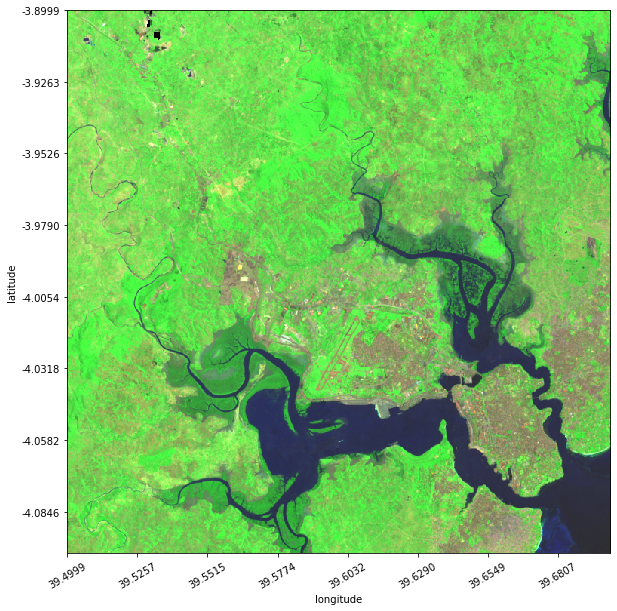

In [20]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

median_composite = create_median_mosaic(cleaned_dataset, cloud_mask)
rgb(median_composite, bands=['swir2', 'nir', 'green'], min_possible=0, max_possible=4000, width=10)
plt.show()

> **Geomedian Mosaic**  
>  Masks clouds from imagery using the geomedian-valued cloud-free pixels in the time series, which maintains the spectral band relationships. 
> That is, this is a median through time for all bands considered collectively rather than separately, as is the case in a median mosaic.
> This algorithm was developed by Geoscience Australia and produces excellent cloud-filtered mosaic products for further analysis. 
<br><br>
For more information, see the following paper: High-Dimensional Pixel Composites from Earth Observation Time Series, by, Dale Roberts, Norman Mueller, and Alexis McIntyre. IEEE Transactions on Geoscience and Remote Sensing, Vol. 55. No. 11, November 2017.

In [21]:
from utils.data_cube_utilities.dc_mosaic import create_hdmedians_multiple_band_mosaic

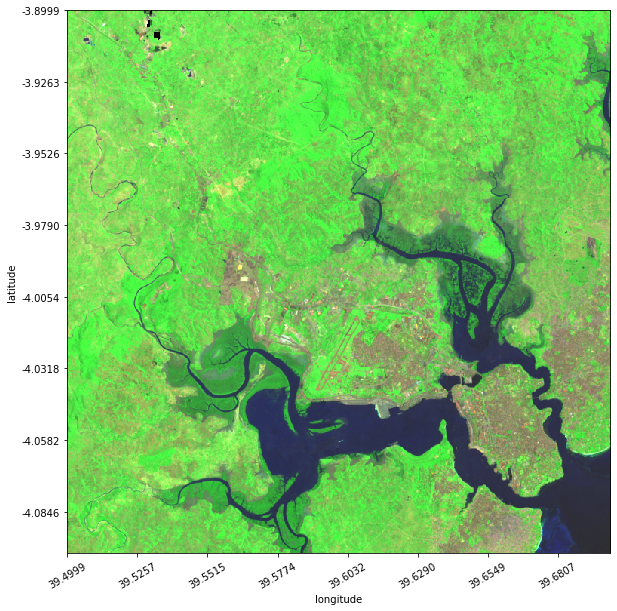

In [22]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

geomedian_composite = create_median_mosaic(cleaned_dataset, cloud_mask)
rgb(geomedian_composite, bands=['swir2', 'nir', 'green'], min_possible=0, max_possible=4000, width=10)
plt.show()

> **Most Recent and Least Recent Mosaic**  
>  Masks clouds from imagery using the most or least recent cloud-free pixels in the time series. 

In [23]:
from utils.data_cube_utilities.dc_mosaic import create_mosaic

**Most Recent Mosaic**

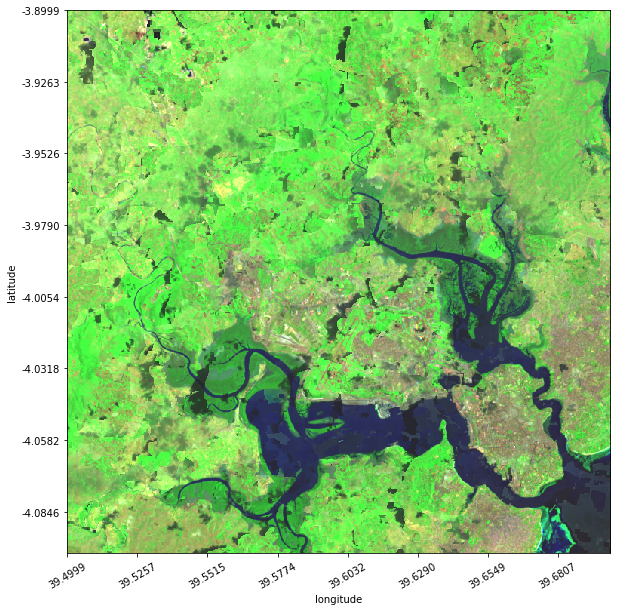

In [24]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

most_recent_composite = create_mosaic(cleaned_dataset, cloud_mask.values)
rgb(most_recent_composite, bands=['swir2', 'nir', 'green'], min_possible=0, max_possible=4000, width=10)
plt.show()

**Least Recent Mosaic**

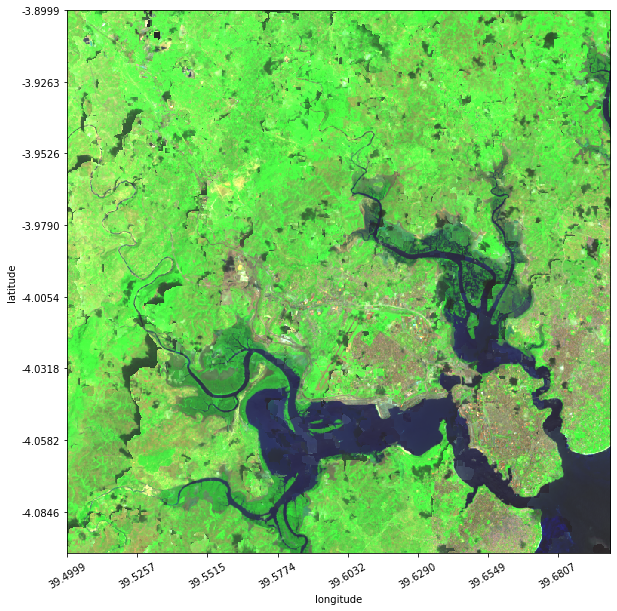

In [25]:
least_recent_composite = create_mosaic(cleaned_dataset, cloud_mask.values, reverse_time=True)
rgb(least_recent_composite, bands=['swir2', 'nir', 'green'], min_possible=0, max_possible=4000, width=10)
plt.show()

> **Max NDVI Mosaic**  
>  Masks clouds from imagery using the Max NDVI across time for cloud-free pixels in the time series. 

In [26]:
from utils.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic

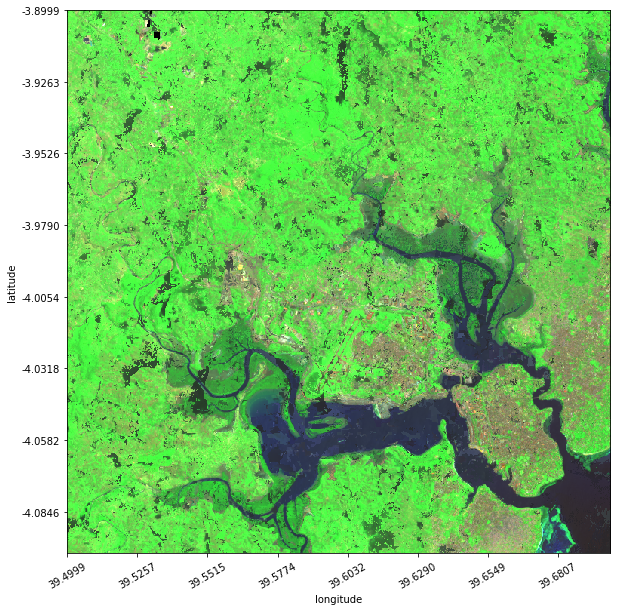

In [27]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

max_ndvi_composite = create_max_ndvi_mosaic(cleaned_dataset, cloud_mask.values)
rgb(max_ndvi_composite, bands=['swir2', 'nir', 'green'], min_possible=0, max_possible=4000, width=10)
plt.show()

## <span id="export">Create GeoTIFF Output Products [&#9652;](#top)</span>

In [28]:
import os
from utils.data_cube_utilities.import_export import export_slice_to_geotiff

# Remove the comment tags (#) to export a GeoTIFF output product
# Change the name of the output file, or it will be overwritten for each run 

output_dir = 'output/geotiffs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
export_slice_to_geotiff(median_composite, output_dir + '/DEMO_median_composite.tif')
# export_slice_to_geotiff(geomedian_composite, output_dir + '/DEMO_geomedian_composite.tif')
# export_slice_to_geotiff(most_recent_composite, output_dir + '/DEMO_most_recent_composite.tif')
# export_slice_to_geotiff(max_ndvi_composite, output_dir + '/DEMO_max_ndvi_composite.tif')

In [29]:
!ls -lah output/geotiffs/

total 14M
drwxr-sr-x 3 jovyan users 4.0K Apr 23 04:30 .
drwxr-sr-x 5 jovyan users 4.0K Apr 23 02:02 ..
-rw-r--r-- 1 jovyan users  14M Apr 23 04:30 DEMO_median_composite.tif
drwxr-sr-x 2 jovyan users  12K Apr 23 02:04 NDVI_Phenology
